In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive/')

In [0]:
import os
import numpy as np
import tensorflow as tf
import pickle
import librosa
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Loading train and test data

In [0]:
def getData(pickle_path):
  speech_list = []
  mag_speech_list = []
  
  if os.path.exists(pickle_path):
    speech_pickle = pickle.load(open(pickle_path, 'rb'))
    print('Pickle already exists! Extracting the data from the pickle')
    
    for speech in speech_pickle:
      S = librosa.stft(speech, n_fft=1024, hop_length=512)
      mag_S = np.abs(S)
      
      speech_list.append(np.transpose(S))
      mag_speech_list.append(np.transpose(mag_S))
      
    return speech_list , mag_speech_list
  
  else:
    print('Pickle doesnt exist! Loading the data from input files')
    return speech_list , mag_speech_list

In [5]:
directory_path = '/content/gdrive/My Drive/Colab Notebooks/'
train_speech_pickle = directory_path + 'hw4_trs.pkl'

train_speech , mag_train_speech  = getData(train_speech_pickle)

Pickle already exists! Extracting the data from the pickle


In [6]:
directory_path = '/content/gdrive/My Drive/Colab Notebooks/'
test_speech_pickle = directory_path + 'hw4_tes.pkl'

test_speech , mag_test_speech = getData(test_speech_pickle)

Pickle already exists! Extracting the data from the pickle


# Creating pairs for Saimese Network

**Positive pairs :**

Speech samples from the same speakers are paired together. Since there are a maximum of 10 speech utterances of the same speaker, we can create a maximum of 45 pairs using $10 \choose 2$ formula

**Negative pairs :**

Speech samples from different speakers are paired together

In [0]:
def get_positive_pairs(L , start , end):
  pairs = []
  for i in range(start , end):
    for j in range(i+1 , end):
      pairs.append([i , j])
  
  if L == 45:
    return pairs
  else:    
    L_pairs = random.choices(pairs , k = L)
    return L_pairs

#Creating a list of speakers from start to end index
#If index of a non-speaker is same a the speaker, then we randomly generate an index 
#till we get an index not belonging to the list of speaker's index list
def get_negative_pairs(L , start , end , max_iter):
  pairs = []
  speakers = list(range(start , end))
  for i in range(0 , L):    
    speaker = random.randrange(start , end)
    non_speaker = random.randrange(0 , max_iter)
    
    while non_speaker in speakers:
      non_speaker = random.randrange(0 , max_iter)
      
    pairs.append([speaker , non_speaker])
  
  return pairs

In [0]:
#Creating a list of all positive and negative pairs together using speech samples
def make_pairs(x , positive_pairs , negative_pairs):
  
  ########Positive########
  left_positive = x[positive_pairs[0][0]]
  right_positive = x[positive_pairs[0][1]]
  
  x_dim = np.shape(left_positive)[0]
  y_dim = np.shape(right_positive)[1]
  
  left_positive = left_positive.reshape((-1 ,  x_dim , y_dim))
  right_positive = right_positive.reshape((-1 ,  x_dim , y_dim))

  for j in range(1 , len(positive_pairs)):
    lp1 = x[positive_pairs[j][0]].reshape((-1 , x_dim , y_dim))
    rp2 = x[positive_pairs[j][1]].reshape((-1 , x_dim , y_dim))
    
    left_positive = np.vstack((left_positive , lp1))
    right_positive = np.vstack((right_positive , rp2))
  
  ########Negative########
  left_negative = x[negative_pairs[0][0]]
  right_negative = x[negative_pairs[0][1]]

  left_negative = left_negative.reshape((-1 , x_dim , y_dim))
  right_negative = right_negative.reshape((-1 , x_dim , y_dim))

  for j in range(1 , len(negative_pairs)):
    ln1 = x[negative_pairs[j][0]].reshape((-1 , x_dim , y_dim))
    rn2 = x[negative_pairs[j][1]].reshape((-1 , x_dim , y_dim))
    
    left_negative = np.vstack((left_negative , ln1))
    right_negative = np.vstack((right_negative , rn2))

  all_left = np.vstack((left_positive , left_negative))
  all_right = np.vstack((right_positive , right_negative))
  
  return all_left , all_right

#Training

## Creating a model

In [0]:
def getModel(x , gru_hidden_units , time_attr , reuse = False):
  cells = []
  for i in range(len(gru_hidden_units)):
    gru_cell = tf.nn.rnn_cell.GRUCell(num_units= gru_hidden_units[i] , kernel_initializer = tf.contrib.layers.xavier_initializer(), reuse=reuse , name='GRU_cell_'+str(i))
    cells.append(gru_cell)
  multi_gru_cells = tf.nn.rnn_cell.MultiRNNCell(cells)

  gru_output , state = tf.nn.dynamic_rnn(multi_gru_cells , x , dtype=tf.float32 , swap_memory = True)
  batch_gru = tf.contrib.layers.batch_norm(gru_output, is_training=True, updates_collections=None)
  
  output = tf.layers.dense(inputs=batch_gru , units=30, activation = tf.nn.tanh ,
                           kernel_initializer = tf.contrib.layers.variance_scaling_initializer(),
                           bias_initializer = tf.zeros_initializer(), 
                           reuse = reuse, name='op')
  
  dropout = tf.nn.dropout(output , keep_prob = 0.9 , name = 'drop')
  
  output1 = tf.layers.dense(inputs=output , units=10, activation = tf.nn.tanh ,
                           kernel_initializer = tf.contrib.layers.variance_scaling_initializer(),
                           bias_initializer = tf.zeros_initializer(), 
                           reuse = reuse, name='op1')
  
  reshapedOutput = tf.reshape(output1,shape = [-1,time_attr*10])
  
  return reshapedOutput

## Defining model parameters

In [0]:
left_input = tf.placeholder(tf.float32, [None, None , 513])
right_input = tf.placeholder(tf.float32, [None, None , 513])
label = tf.placeholder(tf.float32, [None])
time_attr = tf.placeholder(tf.int32)

In [0]:
gru_hidden_units = [256 , 128]
learning_rate = 0.001
num_epochs = 200
num_utterances = 10
L = 45

## Creating a Siamese model 

The model takes two spectograms as input (left and right). Weights of the model are shared across both the sides

In [0]:
left_output = getModel(left_input , gru_hidden_units, time_attr , reuse =  False)
right_output = getModel(right_input , gru_hidden_units , time_attr , reuse = True)

## Model Training

Loss function  - $-y(x_{i},x_{j})log \sigma(z_{i}^T z_{j}) - (1 - y(x_{i}, x_{j}))log(1 - \sigma(z_{i}^T z_{j}))$

Siamese network will try to predict 1 for positive pairs and 0 for negative pairs

In [13]:
#Defining the loss function along with its optimizer
label_pred = tf.reduce_sum(tf.multiply(left_output, right_output),axis=1 , name='dotprod')
label_pred_sig = tf.nn.sigmoid(label_pred)
# loss = -(label) * tf.log(label_pred+ (1e-6)) - (1 - label) * tf.log(1 - label_pred + (1e-6))
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels= label , logits= label_pred)
loss_calculate = tf.reduce_sum(loss)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_calculate)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_list = []
true_label = []
count = 0
flag = True

while flag:
    #Mini batching
    for i in range(0 , len(train_speech), num_utterances):
      start = i
      end = i + num_utterances
      positive_pairs = get_positive_pairs(L , start , end)
      negative_pairs = get_negative_pairs(L , start , end , len(train_speech))

      left , right = make_pairs(mag_train_speech , positive_pairs , negative_pairs)
      
      if count == 0:    
        ones = np.ones(L)
        zeroes = np.zeros(L)

        true_label.extend(ones)
        true_label.extend(zeroes)

      if i == 0:
        all_left = left
        all_right = right
      else:
        all_left = np.vstack((all_left , left))
        all_right = np.vstack((all_right , right))
    
    train_time_attr = all_left.shape[1]
    feed_dict = {left_input: all_left, right_input: all_right, time_attr:train_time_attr, label: true_label}
    train_step.run(feed_dict=feed_dict)

    
    if count%2 == 0:
        loss_calc = loss_calculate.eval(feed_dict=feed_dict)
        loss_list.append((loss_calc))
        print("Epoch %d, loss %g"%(count, loss_calc))
    
    #Once all the epochs are completed, training is stopped
    if count >= num_epochs:
        flag = False  
        
    count+=1

Instructions for updating:
Use tf.cast instead.
Epoch 0, loss 175577
Epoch 2, loss 89604.3
Epoch 4, loss 62977.1
Epoch 6, loss 52203.6
Epoch 8, loss 38445.1
Epoch 10, loss 34441.9
Epoch 12, loss 29935.4
Epoch 14, loss 25550.6
Epoch 16, loss 20449.2
Epoch 18, loss 18564.6
Epoch 20, loss 15437.2
Epoch 22, loss 14139.6
Epoch 24, loss 11703.6
Epoch 26, loss 11090.5
Epoch 28, loss 9425.74
Epoch 30, loss 8693
Epoch 32, loss 7324.52
Epoch 34, loss 6896.5
Epoch 36, loss 6187.86
Epoch 38, loss 5515.79
Epoch 40, loss 5016.19
Epoch 42, loss 4925.97
Epoch 44, loss 4526.18
Epoch 46, loss 4313.6
Epoch 48, loss 4194.38
Epoch 50, loss 3765.99
Epoch 52, loss 3606.02
Epoch 54, loss 3433.05
Epoch 56, loss 3205.41
Epoch 58, loss 3118.43
Epoch 60, loss 3069.79
Epoch 62, loss 2897.85
Epoch 64, loss 2874.73
Epoch 66, loss 2752.17
Epoch 68, loss 2717.27
Epoch 70, loss 2685.33
Epoch 72, loss 2596.65
Epoch 74, loss 2602.96
Epoch 76, loss 2488.8
Epoch 78, loss 2403.98
Epoch 80, loss 2376.8
Epoch 82, loss 2336.95

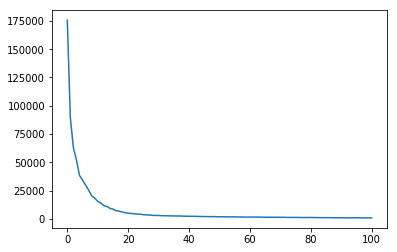

In [14]:
plt.plot(loss_list)

# Testing

## Creating positive and negative pairs for testing

In [0]:
true_label = []
for i in range(0 , len(test_speech), num_utterances):
  start = i
  end = i + num_utterances
  test_positive_pairs = get_positive_pairs(L , start , end)
  test_negative_pairs = get_negative_pairs(L , start , end , len(test_speech))

  test_left , test_right = make_pairs(mag_test_speech , test_positive_pairs , test_negative_pairs)
  
  
  ones = np.ones(L)
  zeroes = np.zeros(L)

  true_label.extend(ones)
  true_label.extend(zeroes)

  if i == 0:
    test_all_left = test_left
    test_all_right = test_right
  else:
    test_all_left = np.vstack((test_all_left , test_left))
    test_all_right = np.vstack((test_all_right , test_right))

## Predicting output for test data

In [0]:
test_time_attr = test_all_left.shape[1]
feed_dict = {left_input: test_all_left, right_input: test_all_right, time_attr:test_time_attr}

predicted_output = label_pred_sig.eval(feed_dict=feed_dict)

## Binarising predicted output

In [0]:
for i in range(len(predicted_output)):
  if predicted_output[i] >= 0.5:
    predicted_output[i] = 1
  else:
    predicted_output[i] = 0

## Calculating the accuracy of test data

In [18]:
accuracy = sum(predicted_output == true_label)
print('Accuracy for test data : ' + str(accuracy/len(predicted_output)))

Accuracy for test data : 0.6833333333333333
